# Data processing 
from initial_micro_data_wrangling as netcdf

In [1]:
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# gsw oceanic toolbox: http://www.teos-10.org/pubs/Getting_Started.pdf
import gsw
from scipy.io import loadmat

In [2]:
arctic_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/arctic_mmp.nc"
arctic_dataset = Dataset(arctic_nc)
arctic_ds = xr.open_dataset(arctic_nc)

## Omit all NaNs

In [ ]:
mask = 1-(np.isnan(ds1.0.values) | np.isnan(ds2.0.values) | np.isnan(ds3.0.values))
# Make sure there are no nans
mask = np.isnan(arctic_ds.TEMPERATURE)*np.isnan(arctic_ds.PSAL)*np.isnan(arctic_ds.EPSILON)
print(mask)
# ds['pot_temp'] = xr.where(mask,np.nan,ds.pot_temp)
ds['temp'] = xr.where(mask,np.nan,ds.temp)
ds['salt'] = xr.where(mask,np.nan,ds.salt)
ds['eps'] = xr.where(mask,np.nan,ds.eps)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (1275097842.py, line 1)

In [ ]:
# trace back depth as a variable from pressure (how useful?)
arctic_ds["z"] = -arctic_ds.PRESSURE # pressure in dbar to z

## Bin data

In [3]:
arctic_ds.TEMPERATURE.values

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

In [4]:
arctic_ds["depth"]

<xarray.DataArray 'depth' (depth: 1201)>
array([   0,    1,    2, ..., 1198, 1199, 1200])
Dimensions without coordinates: depth

In [5]:
# correlate depth samples to actual depth
# assume that pressure (decibars) of the water correlates to the depth (m)
multiply_factor = arctic_ds.PRESSURE.max().item()/arctic_ds.depth.max().item()
arctic_ds["depth"] = arctic_ds["depth"]*multiply_factor

In [36]:
bin_ds = arctic_ds
# group data by depth bins
# adjust the labels to reflect the start of each interval
bin_size = np.arange(0, 300.1, 10)
bin_labels = [edge for edge in bin_size[:-1]]
grouped = bin_ds.groupby_bins('depth', bin_size, labels=bin_labels)
# calculate mean of each bin
binned_data = grouped.mean(dim='depth')
binned_data = binned_data.rename({'depth_bins': 'depth'})
binned_data

<xarray.Dataset>
Dimensions:      (depth: 30, profiles: 871, single: 1)
Coordinates:
  * depth        (depth) float64 0.0 10.0 20.0 30.0 ... 260.0 270.0 280.0 290.0
Dimensions without coordinates: profiles, single
Data variables:
    LATITUDE     (depth, profiles, single) float64 65.23 65.24 ... 65.73 65.73
    LONGITUDE    (depth, profiles, single) float64 -166.6 -166.6 ... -168.8
    TIME         (depth, profiles, single) float64 7.362e+05 ... 7.362e+05
    EPSILON      (depth, profiles) float64 1.177e-05 1.305e-06 ... nan nan
    PRESSURE     (depth, single) float64 5.125 15.12 25.12 ... 275.1 285.1 295.1
    PSAL         (depth, profiles) float64 12.29 0.0 11.81 0.0 ... 0.0 0.0 0.0
    TEMPERATURE  (depth, profiles) float64 11.06 11.06 11.06 ... nan nan nan

In [7]:
lat = binned_data.LATITUDE
lon = binned_data.LONGITUDE

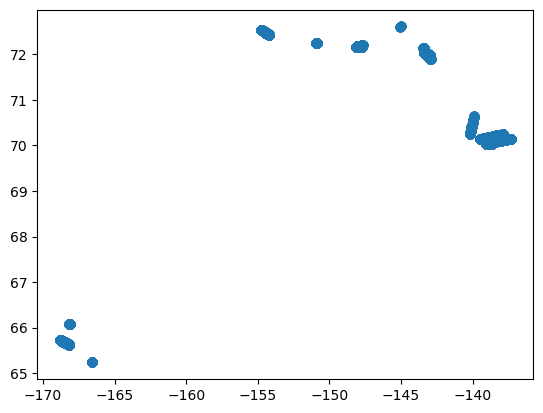

In [8]:
plt.scatter(lon, lat)

Text(0.5, 0, 'Temperature')

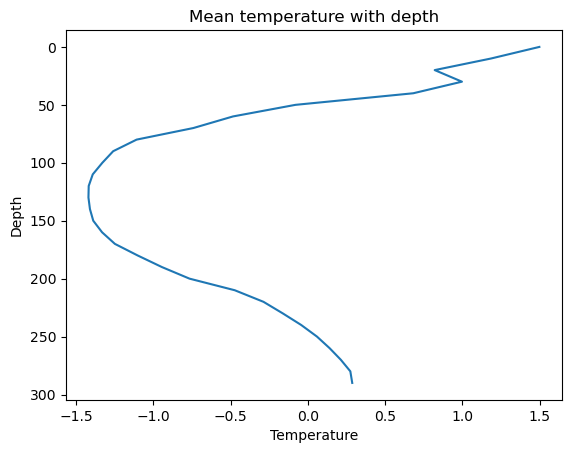

In [9]:
plt.plot(binned_data.TEMPERATURE.mean(dim="profiles"),binned_data.depth)
plt.gca().invert_yaxis()  # invert the y-axis (depth axis)
plt.title("Mean temperature with depth")
plt.ylabel("Depth")
plt.xlabel("Temperature")

In nc dataset, can find time, lat, lon, epsilon, pressure, psal, temperature.
dimensions for this dataset are lengths, profiles and depth

lit review on Arctic and CC and beaufort sea

Understabding Arctic turbulence: beaufort gyre

The Arctic Ocean's beaufort gyre

Text(0.5, 1.0, 'Pressure with depth')

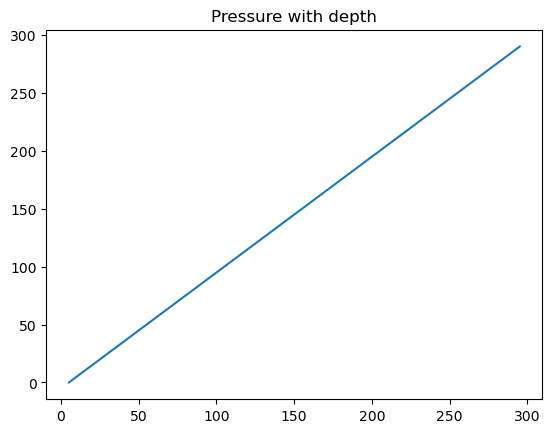

In [10]:
binned_data
plt.plot(binned_data.PRESSURE, binned_data.depth)
plt.title("Pressure with depth")

## Omit NaNs

In [37]:
mask = ~np.isnan(binned_data["TEMPERATURE"]) & ~np.isnan(binned_data["PSAL"]) & ~np.isnan(binned_data["EPSILON"])
#ds_masked = binned_data.where(mask, drop=True)
#ds_masked = binned_data.where(mask).dropna(dim='depth')
ds_masked = binned_data.where(~mask, np.nan)

In [38]:
# Check the shape of the original dataset
print("Original dataset shape:", binned_data.sizes)
print("Original dataset NaN count:\n", binned_data.isnull().sum())

# Check the shape of the masked dataset
print("Masked dataset shape:", ds_masked.sizes)
print("Masked dataset NaN count:\n", ds_masked.isnull().sum())

Original dataset shape: Frozen({'depth': 30, 'profiles': 871, 'single': 1})
Original dataset NaN count:
 <xarray.Dataset>
Dimensions:      ()
Data variables:
    LATITUDE     int64 0
    LONGITUDE    int64 0
    TIME         int64 0
    EPSILON      int64 12171
    PRESSURE     int64 0
    PSAL         int64 59
    TEMPERATURE  int64 11907
Masked dataset shape: Frozen({'depth': 30, 'profiles': 871, 'single': 1})
Masked dataset NaN count:
 <xarray.Dataset>
Dimensions:      ()
Data variables:
    LATITUDE     int64 13902
    LONGITUDE    int64 13902
    TIME         int64 13902
    EPSILON      int64 26073
    PRESSURE     int64 13902
    PSAL         int64 13961
    TEMPERATURE  int64 25809


## Convert to standard size of dataframe
correct variable names

# apply mask to get rid of rows with NaN values in var2 and var3
mask = xr.ufuncs.logical_not(xr.ufuncs.isnan(binned_data['TEMPERATURE']) | xr.ufuncs.isnan(binned_data['PSAL']) | xr.ufuncs.isnan(binned_data['EPSILON']))
ds_masked = binned_ds.where(mask, drop=True)

## Other plots

Text(0.5, 1.0, 'Mean temperature, salinity and epsilon with depth')

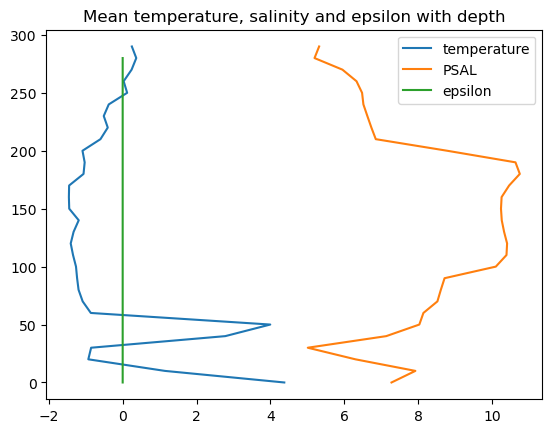

In [13]:
ds_masked
plt.plot(ds_masked.TEMPERATURE.mean(dim="profiles"),ds_masked.depth, label = "temperature")
plt.plot(ds_masked.PSAL.mean(dim="profiles"),ds_masked.depth, label = "PSAL")
plt.plot(ds_masked.EPSILON.mean(dim="profiles"),ds_masked.depth, label = "epsilon")
#plt.plot(ds_masked.PRESSURE.mean(dim="profiles"),ds_masked.depth, label = "pressure")

plt.legend()
plt.title("Mean temperature, salinity and epsilon with depth")

Text(0.5, 1.0, 'Mean temperature, salinity and epsilon with depth')

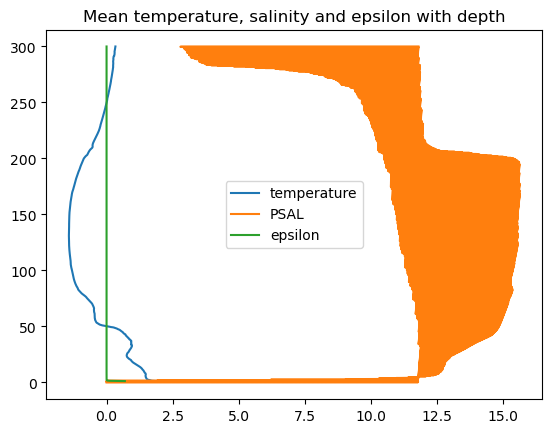

In [14]:
plt.plot(arctic_ds.TEMPERATURE.mean(axis=0),arctic_ds.depth, label = "temperature")
plt.plot(arctic_ds.PSAL.mean(axis=0),arctic_ds.depth, label = "PSAL")
plt.plot(arctic_ds.EPSILON.mean(axis=0),arctic_ds.depth, label = "epsilon")
#plt.plot(arctic_ds.PRESSURE.mean(axis=0),arctic_ds.depth)

plt.legend()
plt.title("Mean temperature, salinity and epsilon with depth")

Text(0.5, 1.0, 'Mean temperature, salinity and epsilon with depth')

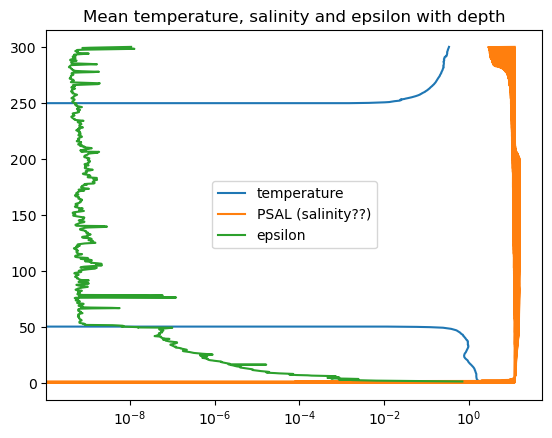

In [15]:
plt.plot(arctic_ds.TEMPERATURE.mean(axis=0),arctic_ds.depth, label = "temperature")
plt.plot(arctic_ds.PSAL.mean(axis=0),arctic_ds.depth, label = "PSAL (salinity??)")
plt.plot(arctic_ds.EPSILON.mean(axis=0),arctic_ds.depth, label = "epsilon")
#plt.plot(arctic_ds.PRESSURE.mean(axis=0),arctic_ds.depth)

plt.legend()
plt.xscale('log')
plt.title("Mean temperature, salinity and epsilon with depth")

plot histograms and distributions

In [27]:
NEW_nc = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/preprocessing/alberto_ds.nc"
NEW_ds = xr.open_dataset(NEW_nc)
NEW_ds

<xarray.Dataset>
Dimensions:    (depth: 69, profile: 351)
Coordinates:
  * depth      (depth) int64 0 10 20 30 40 50 60 ... 620 630 640 650 660 670 680
    longitude  (profile) float64 ...
    latitude   (profile) float64 ...
Dimensions without coordinates: profile
Data variables:
    T          (depth, profile) float64 ...
    S          (depth, profile) float64 ...
    eps        (depth, profile) float64 ...

## Change variable names and save for preprocessing

In [39]:
binned_data = binned_data.rename({'PSAL': 'S', 'TEMPERATURE': 'T', 'LONGITUDE': 'longitude', 'LATITUDE':'latitude', "EPSILON":"eps"})
binned_data.coords["depth"] = binned_data.coords["depth"].astype(int)

In [40]:
binned_data.to_netcdf('arctic_mix.nc')

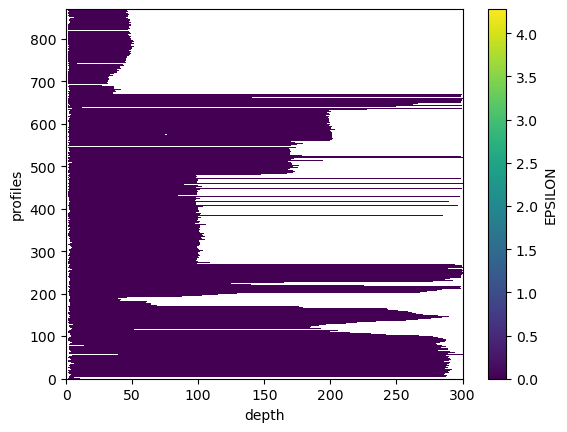

In [24]:
arctic_ds.EPSILON.plot()

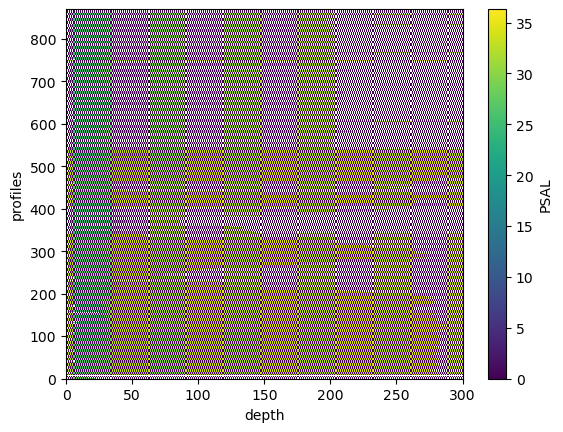

In [19]:
arctic_ds.PSAL.plot()

In [47]:
from func_preprocessing import gws_conversions, TS_derivative

dataset = gws_conversions(binned_data)

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (30, 871) and arg 1 with shape (30, 871, 1).

## Add potential temperature

Text(0.5, 1.0, 'Mean potential temperature with depth')

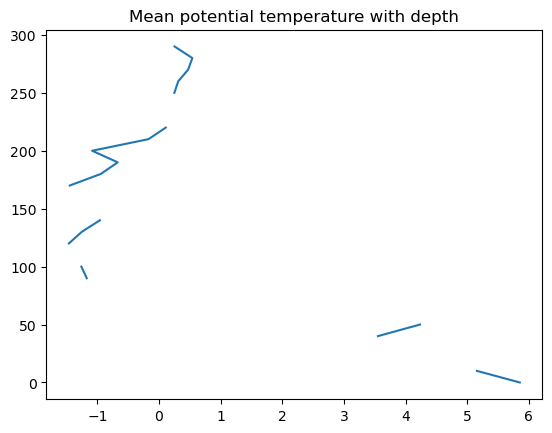

In [19]:
ds_masked['pot_temp'] = gsw.conversions.pt0_from_t(ds_masked.PSAL,ds_masked.TEMPERATURE,ds_masked.PRESSURE)
plt.plot(ds_masked.pot_temp.mean(dim="profiles"),ds_masked.depth)
plt.title("Mean potential temperature with depth")

## Calculate kappa

In [20]:
# calculate Conservative Temperature from potential temperature
pt = gsw.pt0_from_t(ds_masked['PSAL'], ds_masked['pot_temp'], ds_masked['PRESSURE'])
CT = gsw.CT_from_pt(ds_masked['PSAL'], pt)

# calculate kappa using gsw_kappa function
kappa = gsw.kappa(ds_masked['PSAL'], CT, ds_masked['PSAL'])
# add kappa as a new variable in the xarray dataset
ds_masked['kappa'] = kappa

## Calculate N^2
Buoyancy-frequency squared
https://teos-10.org/pubs/gsw/html/gsw_Nsquared.html

## Calculate height above bottom

In [21]:
GEBCO_ds = "/Users/Lisanne/Documents/AI4ER/Mres/ArcticTurbulence/data/gebco_2022_n80.0_s63.0_w-170.0_e-130.0.nc"
#bathy_dataset = Dataset(GEBCO_ds)
bathy_ds = xr.open_dataset(GEBCO_ds)

In [23]:
# Interpolate the bathymetry dataset to the same grid as the masked dataset
bathy_interp = bathy_ds.interp_like(ds_masked, method='linear')

# Add the bathymetry data to the masked dataset
ds_masked['bathymetry'] = bathy_interp['elevation']

In [36]:
bathymetry_broadcast[0, 0, :]

<xarray.DataArray 'elevation' (depth: 30)>
array([-27., -27., -27., -27., -27., -27., -27., -27., -27., -27., -27.,
       -27., -27., -27., -27., -27., -27., -27., -27., -27., -27., -27.,
       -27., -27., -27., -27., -27., -27., -27., -27.])
Coordinates:
    lat      float64 63.0
    lon      float64 -170.0
  * depth    (depth) float64 0.0 10.0 20.0 30.0 40.0 ... 260.0 270.0 280.0 290.0
Attributes:
    standard_name:       height_above_mean_sea_level
    long_name:           Elevation relative to sea level
    units:               m
    grid_mapping:        crs
    sdn_parameter_urn:   SDN:P01::ALATZZ01
    sdn_parameter_name:  Sea floor height (above mean sea level) {bathymetric...
    sdn_uom_urn:         SDN:P06::ULAA
    sdn_uom_name:        Metres

In [31]:
bathy_interp = bathy_ds.interp_like(ds_masked, method='linear')
bathymetry_broadcast = xr.broadcast(bathy_interp['elevation'], ds_masked['depth'])[0]
# Broadcast the bathymetry data from 2D to 3D by adding the profile dimension
bathymetry_broadcast = xr.broadcast(bathy_interp['elevation'], ds_masked['depth'])[0]

# Add the bathymetry data to the masked dataset
ds_masked['bathymetry'] = bathymetry_broadcast

ValueError: cannot select a dimension to squeeze out which has length greater than one

In [24]:
ds_masked["hab"] = ds_masked['bathymetry'] + ds_masked["depth"] 
# correct for the case where bathymetry is positive
#ds_masked["hab"] = ds_masked['bathymetry'].where(ds_masked['bathymetry'] > 0, 0) - ds_masked['depth']
# Make hab nan where there's no data
#ds_masked["hab"] = xr.where(np.isnan(ds_masked.pot_temp),np.nan,ds_masked.hab)

In [25]:
ds_masked["hab"]

<xarray.DataArray 'hab' (lat: 4080, lon: 9600, depth: 30)>
array([[[  -27.,   -17.,    -7., ...,   243.,   253.,   263.],
        [  -27.,   -17.,    -7., ...,   243.,   253.,   263.],
        [  -27.,   -17.,    -7., ...,   243.,   253.,   263.],
        ...,
        [ 1416.,  1426.,  1436., ...,  1686.,  1696.,  1706.],
        [ 1411.,  1421.,  1431., ...,  1681.,  1691.,  1701.],
        [ 1388.,  1398.,  1408., ...,  1658.,  1668.,  1678.]],

       [[  -26.,   -16.,    -6., ...,   244.,   254.,   264.],
        [  -26.,   -16.,    -6., ...,   244.,   254.,   264.],
        [  -25.,   -15.,    -5., ...,   245.,   255.,   265.],
        ...,
        [ 1535.,  1545.,  1555., ...,  1805.,  1815.,  1825.],
        [ 1562.,  1572.,  1582., ...,  1832.,  1842.,  1852.],
        [ 1590.,  1600.,  1610., ...,  1860.,  1870.,  1880.]],

       [[  -25.,   -15.,    -5., ...,   245.,   255.,   265.],
        [  -25.,   -15.,    -5., ...,   245.,   255.,   265.],
        [  -24.,   -14.,    -4., ...,   246.,   256.,   266.],
        ...,
...
        ...,
        [-3363., -3353., -3343., ..., -3093., -3083., -3073.],
        [-3360., -3350., -3340., ..., -3090., -3080., -3070.],
        [-3358., -3348., -3338., ..., -3088., -3078., -3068.]],

       [[-3301., -3291., -3281., ..., -3031., -3021., -3011.],
        [-3301., -3291., -3281., ..., -3031., -3021., -3011.],
        [-3301., -3291., -3281., ..., -3031., -3021., -3011.],
        ...,
        [-3364., -3354., -3344., ..., -3094., -3084., -3074.],
        [-3361., -3351., -3341., ..., -3091., -3081., -3071.],
        [-3359., -3349., -3339., ..., -3089., -3079., -3069.]],

       [[-3300., -3290., -3280., ..., -3030., -3020., -3010.],
        [-3300., -3290., -3280., ..., -3030., -3020., -3010.],
        [-3300., -3290., -3280., ..., -3030., -3020., -3010.],
        ...,
        [-3364., -3354., -3344., ..., -3094., -3084., -3074.],
        [-3362., -3352., -3342., ..., -3092., -3082., -3072.],
        [-3360., -3350., -3340., ..., -3090., -3080., -3070.]]])
Coordinates:
  * depth    (depth) float64 0.0 10.0 20.0 30.0 40.0 ... 260.0 270.0 280.0 290.0
  * lat      (lat) float64 63.0 63.01 63.01 63.01 ... 79.99 79.99 79.99 80.0
  * lon      (lon) float64 -170.0 -170.0 -170.0 -170.0 ... -130.0 -130.0 -130.0

In [29]:
plt.plot(ds_masked.hab.ravel(),ds_masked.depth)
plt.title("Mean potential temperature with depth")

AttributeError: 'DataArray' object has no attribute 'ravel'

In [21]:
ds_masked

<xarray.Dataset>
Dimensions:      (depth: 30, profiles: 871, single: 1, lat: 4080, lon: 9600)
Coordinates:
  * depth        (depth) float64 0.0 10.0 20.0 30.0 ... 260.0 270.0 280.0 290.0
  * lat          (lat) float64 63.0 63.01 63.01 63.01 ... 79.99 79.99 79.99 80.0
  * lon          (lon) float64 -170.0 -170.0 -170.0 ... -130.0 -130.0 -130.0
Dimensions without coordinates: profiles, single
Data variables:
    LATITUDE     (depth, profiles, single) float64 nan nan nan ... 65.73 65.73
    LONGITUDE    (depth, profiles, single) float64 nan nan nan ... -168.8 -168.8
    TIME         (depth, profiles, single) float64 nan nan ... 7.362e+05
    EPSILON      (depth, profiles) float64 nan nan nan nan ... nan nan nan nan
    PRESSURE     (depth, single, profiles) float64 nan nan nan ... 295.1 295.1
    PSAL         (depth, profiles) float64 nan nan nan 0.0 ... 0.0 0.0 0.0 0.0
    TEMPERATURE  (depth, profiles) float64 nan nan nan 12.34 ... nan nan nan nan
    pot_temp     (depth, profiles, single) float64 nan nan nan ... nan nan nan
    kappa        (depth, profiles, single) float64 nan nan nan ... nan nan nan
    bathymetry   (lat, lon) int16 -27 -27 -27 -26 ... -3366 -3364 -3362 -3360
    hab          (lat, lon, depth) float64 -27.0 -17.0 ... -3.08e+03 -3.07e+03

In [ ]:
# Define height above bottom
ds['hab'] = ds.z - ds.depth
# Correct for where profiles might have negative hab
ds['hab'] = xr.where((ds.hab < 0) & (~np.isnan(ds.pot_temp)), 0, ds.hab)
# Make hab nan where there's no data
ds['hab'] = xr.where(np.isnan(ds.pot_temp),np.nan,ds.hab)

In [54]:
# Create a new dataset with dimensions 'depth' and 'profiles'
bathymetry_ds = xr.Dataset(
    coords={
        'depth': ds_masked.depth.values,
        'profiles': ds_masked.profiles.values
    }
)

# Define a function to interpolate bathymetry values
def interpolate_bathy(lat, lon):
    bathy_value = bathy_interp.elevation.sel(lat=lat, lon=lon, method='nearest').values
    return bathy_value

# Apply the function to each combination of latitude and longitude in ds_masked
bathymetry_ds['elevation'] = xr.apply_ufunc(
    interpolate_bathy, 
    ds_masked.LATITUDE, 
    ds_masked.LONGITUDE, 
    dask='parallelized', 
    output_dtypes=[float]
)# Merge the bathymetry data back into the original dataset
ds_masked = xr.merge([ds_masked, bathymetry_ds])

<xarray.Dataset>
Dimensions:   (depth: 30, profiles: 871)
Coordinates:
  * depth     (depth) float64 0.0 10.0 20.0 30.0 ... 260.0 270.0 280.0 290.0
  * profiles  (profiles) int64 0 1 2 3 4 5 6 7 ... 864 865 866 867 868 869 870
Data variables:
    *empty*

In [254]:
import xarray as xr
import rasterio as rio

# Load the dataset
ds = ds_masked

# Import the rasterio extension
ds.rio.set_crs(ds.attrs['crs'], inplace=True)
bathy_ds = bathy_ds.rio.reproject("EPSG:4326")

# Print the projection
print(ds.rio.crs)

ModuleNotFoundError: No module named 'rasterio'

## derivatives

In [22]:
arctic_ds["dTdz"] = arctic_ds.TEMPERATURE.differentiate('depth')
arctic_ds['dSdz'] = arctic_ds.PSAL.differentiate('depth')
#arctic_ds['N2'] = -9.8/1027*ds2.gamma.differentiate('z')


Text(0.5, 1.0, 'Mean sailinty derivative with depth')

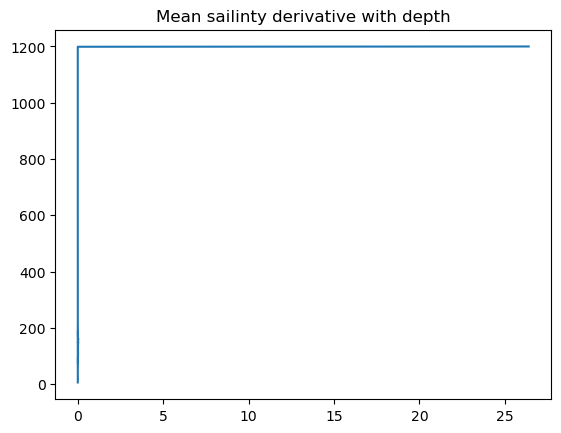

In [23]:
plt.plot(arctic_ds.dSdz.mean(axis=0),arctic_ds.depth)
plt.title("Mean sailinty derivative with depth")

Text(0.5, 1.0, 'Mean temperature derivative with depth')

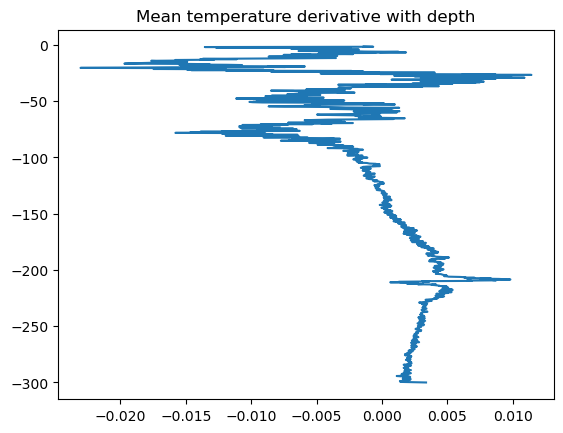

In [25]:
plt.plot(arctic_ds.dTdz.mean(axis=0),arctic_ds.z)
plt.title("Mean temperature derivative with depth")

In [26]:
# check to see if any profiles are dodgy!!!
# make jupyter notebook for that
arctic_ds.profiles

<xarray.DataArray 'profiles' (profiles: 871)>
array([  0,   1,   2, ..., 868, 869, 870])
Dimensions without coordinates: profiles